In [106]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(data.table)
library(ggplot2)
library(corrio)
options(repr.plot.width = 22, repr.plot.height = 12)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")
aqi <- fread("/kaggle/input/delhi-aqi/aqidata.csv")
aqi <- aqi[year(Date)!=2025]

aqi[aqi<100, category := "Good or satisfactory"]
aqi[aqi>100, category := "Moderate"]
aqi[aqi>200, category := "Poor"]
aqi[aqi>300, category := "Very poor or severe"]
aqi$category <- factor(aqi$category, 
                       levels = c("Good or satisfactory", "Moderate", 
                                  "Poor", "Very poor or severe"))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ERROR: Error in library(corrio): there is no package called ‘corrio’


# How is AQI calculated?

1. The Sub-indices for individual pollutants at a monitoring location are calculated using its 24-hourly average concentration value (8-hourly in case of CO and O3) and health breakpoint concentration range. The worst sub-index is the AQI for that location.

2. All the eight pollutants may not be monitored at all the locations. Overall AQI is calculated only if data are available for minimum three pollutants out of which one should necessarily be either PM2.5 or PM10. Else, data are considered insufficient for calculating
AQI. Similarly, a minimum of 16 hours’ data is considered necessary for calculating subindex.

3. The sub-indices for monitored pollutants are calculated and disseminated, even if data are inadequate for determining AQI. The Individual pollutant-wise sub-index will provide air quality status for that pollutant.

4. The web-based system is designed to provide AQI on real time basis. It is an automated system that captures data from continuous monitoring stations without human intervention, and displays AQI based on running average values (e.g. AQI at 6am on a day will incorporate data from 6am on previous day to the current day).

5. For manual monitoring stations, an AQI calculator is developed wherein data can be fed manually to get AQI value. 

# Description of Sample

In [111]:
aqi[,.N,City]

City,N
<chr>,<int>
Delhi,2889
Greater Noida,2398


# Which is the day with worst AQI in each year?

It is usually a day in November which has the worst AQI in Delhi and Greater Noida. But in Greater Noida, in 2018, June 13-14 were the worst days with an AQI of 500! In 2024, the worst AQI in Greater Noida was recorded on Jan 14.


## Delhi

In [ ]:
aqi[City=="Delhi", .(Worst_day_of_year = Date[aqi == max(aqi)],
        Worst_AQI = max(aqi)), .(year(Date))][order(year)]


## Greater Noida

# Number of days in different categories of AQI in each year

In [ ]:

t <- aqi[!is.na(category), .N, .(year(Date), category)]
## dcast(t, year~category, fun.aggregate=sum)

In [73]:
# aqi[aqi<50, category := "Good"]
# aqi[aqi>50, category := "Satisfactory"]
# aqi[aqi>100, category := "Moderate"]
# aqi[aqi>200, category := "Poor"]
# aqi[aqi>300, category := "Very poor"]
# aqi[aqi>400, category := "Severe"]
# aqi$category <- factor(aqi$category, 
#                        levels = c("Good", "Satisfactory", "Moderate", 
#                                   "Poor", "Very poor", "Severe"))
t <- aqi[!is.na(category), .N, .(year(Date), category, City)]
dcast(t, City+year~category, fun.aggregate=sum)

Using 'N' as value column. Use 'value.var' to override



City,year,Good or satisfactory,Moderate,Poor,Very poor or severe
<chr>,<int>,<int>,<int>,<int>,<int>
Delhi,2017,38,95,110,88
Delhi,2018,53,101,116,95
Delhi,2019,59,121,102,81
Delhi,2020,96,126,75,64
Delhi,2021,72,124,80,88
Delhi,2022,65,95,130,72
Delhi,2023,60,144,77,82
Delhi,2024,64,142,73,86
Greater Noida,2018,47,58,43,64


2020 was the best year with lowest number of days with very poor or severe level of air pollution and highest number of days with good or satisfactory air. This was a result of Covid pandemic closures.



# Which are the best and the worst months of the year?

* In months years, July or August are the months with highest number of days when air quality is good or satisfactory. 
* On the other hand, November, December or January are the months with highest number of days with very poor or severe quality of air.

In [72]:
t <-aqi[category %in% c("Very poor or severe", "Good or satisfactory"),
         .(Days=.N),.(City, year(Date), month(Date), category)][year!=2025][year!=2017]
t1 <- t[,.(maxdays=max(Days)),.(City, year, category)]
t <- merge(t,t1, by = c("City", "year", "category"))

t <- t[Days==maxdays,.(City, year, category, month)]
t$month <- month.name[t$month]
t <- t[,.(Month=paste(month, sep=",", collapse=", ")),.(City, Year=year, category)]
dcast.data.table(t, Year~City+category, value.var="Month", fun.aggregate=function(x) paste(x, collapse=""))


Year,Delhi_Good or satisfactory,Delhi_Very poor or severe,Greater Noida_Good or satisfactory,Greater Noida_Very poor or severe
<int>,<chr>,<chr>,<chr>,<chr>
2018,August,December,August,December
2019,August,December,September,December
2020,August,December,August,December
2021,September,November,September,"January, November"
2022,July,December,July,December
2023,July,December,July,November
2024,August,"January, November",August,January


# Comparing air quality of Delhi and Greater Noida

* Air quality of Delhi and Greater Noida is very poor.
* The seasonal pattern of air quality is very similar suggesting that the causes of air pollution in Delhi and Greater Noida are same.
* In 2018 to 2021, the air quality of Greater Noida was marginally worse than in Delhi. In recent years, air quality of Delhi has been worse.

In [109]:
p <- aqi[Date>"2018-06-01",
         .(Min = min(aqi),
           Mean = mean(aqi),
           Max = max(aqi)),
         .(City,
           Date=as.Date(paste0(year(Date), "-",
                               month(Date), "-15"
                      )))]

p


City,Date,Min,Mean,Max
<chr>,<date>,<int>,<dbl>,<int>
Delhi,2018-06-15,72,203.24138,447
Delhi,2018-07-15,54,104.00000,182
Delhi,2018-08-15,62,111.38710,241
Delhi,2018-09-15,52,111.63333,219
Delhi,2018-10-15,143,268.93548,401
Delhi,2018-11-15,171,335.03333,426
Delhi,2018-12-15,194,360.51613,450
Delhi,2019-01-15,104,327.70968,444
Delhi,2019-02-15,100,242.39286,382


Warning message in melt.data.table(p, id = c("City", "Date")):
“'measure.vars' [Min, Mean, Max, ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”


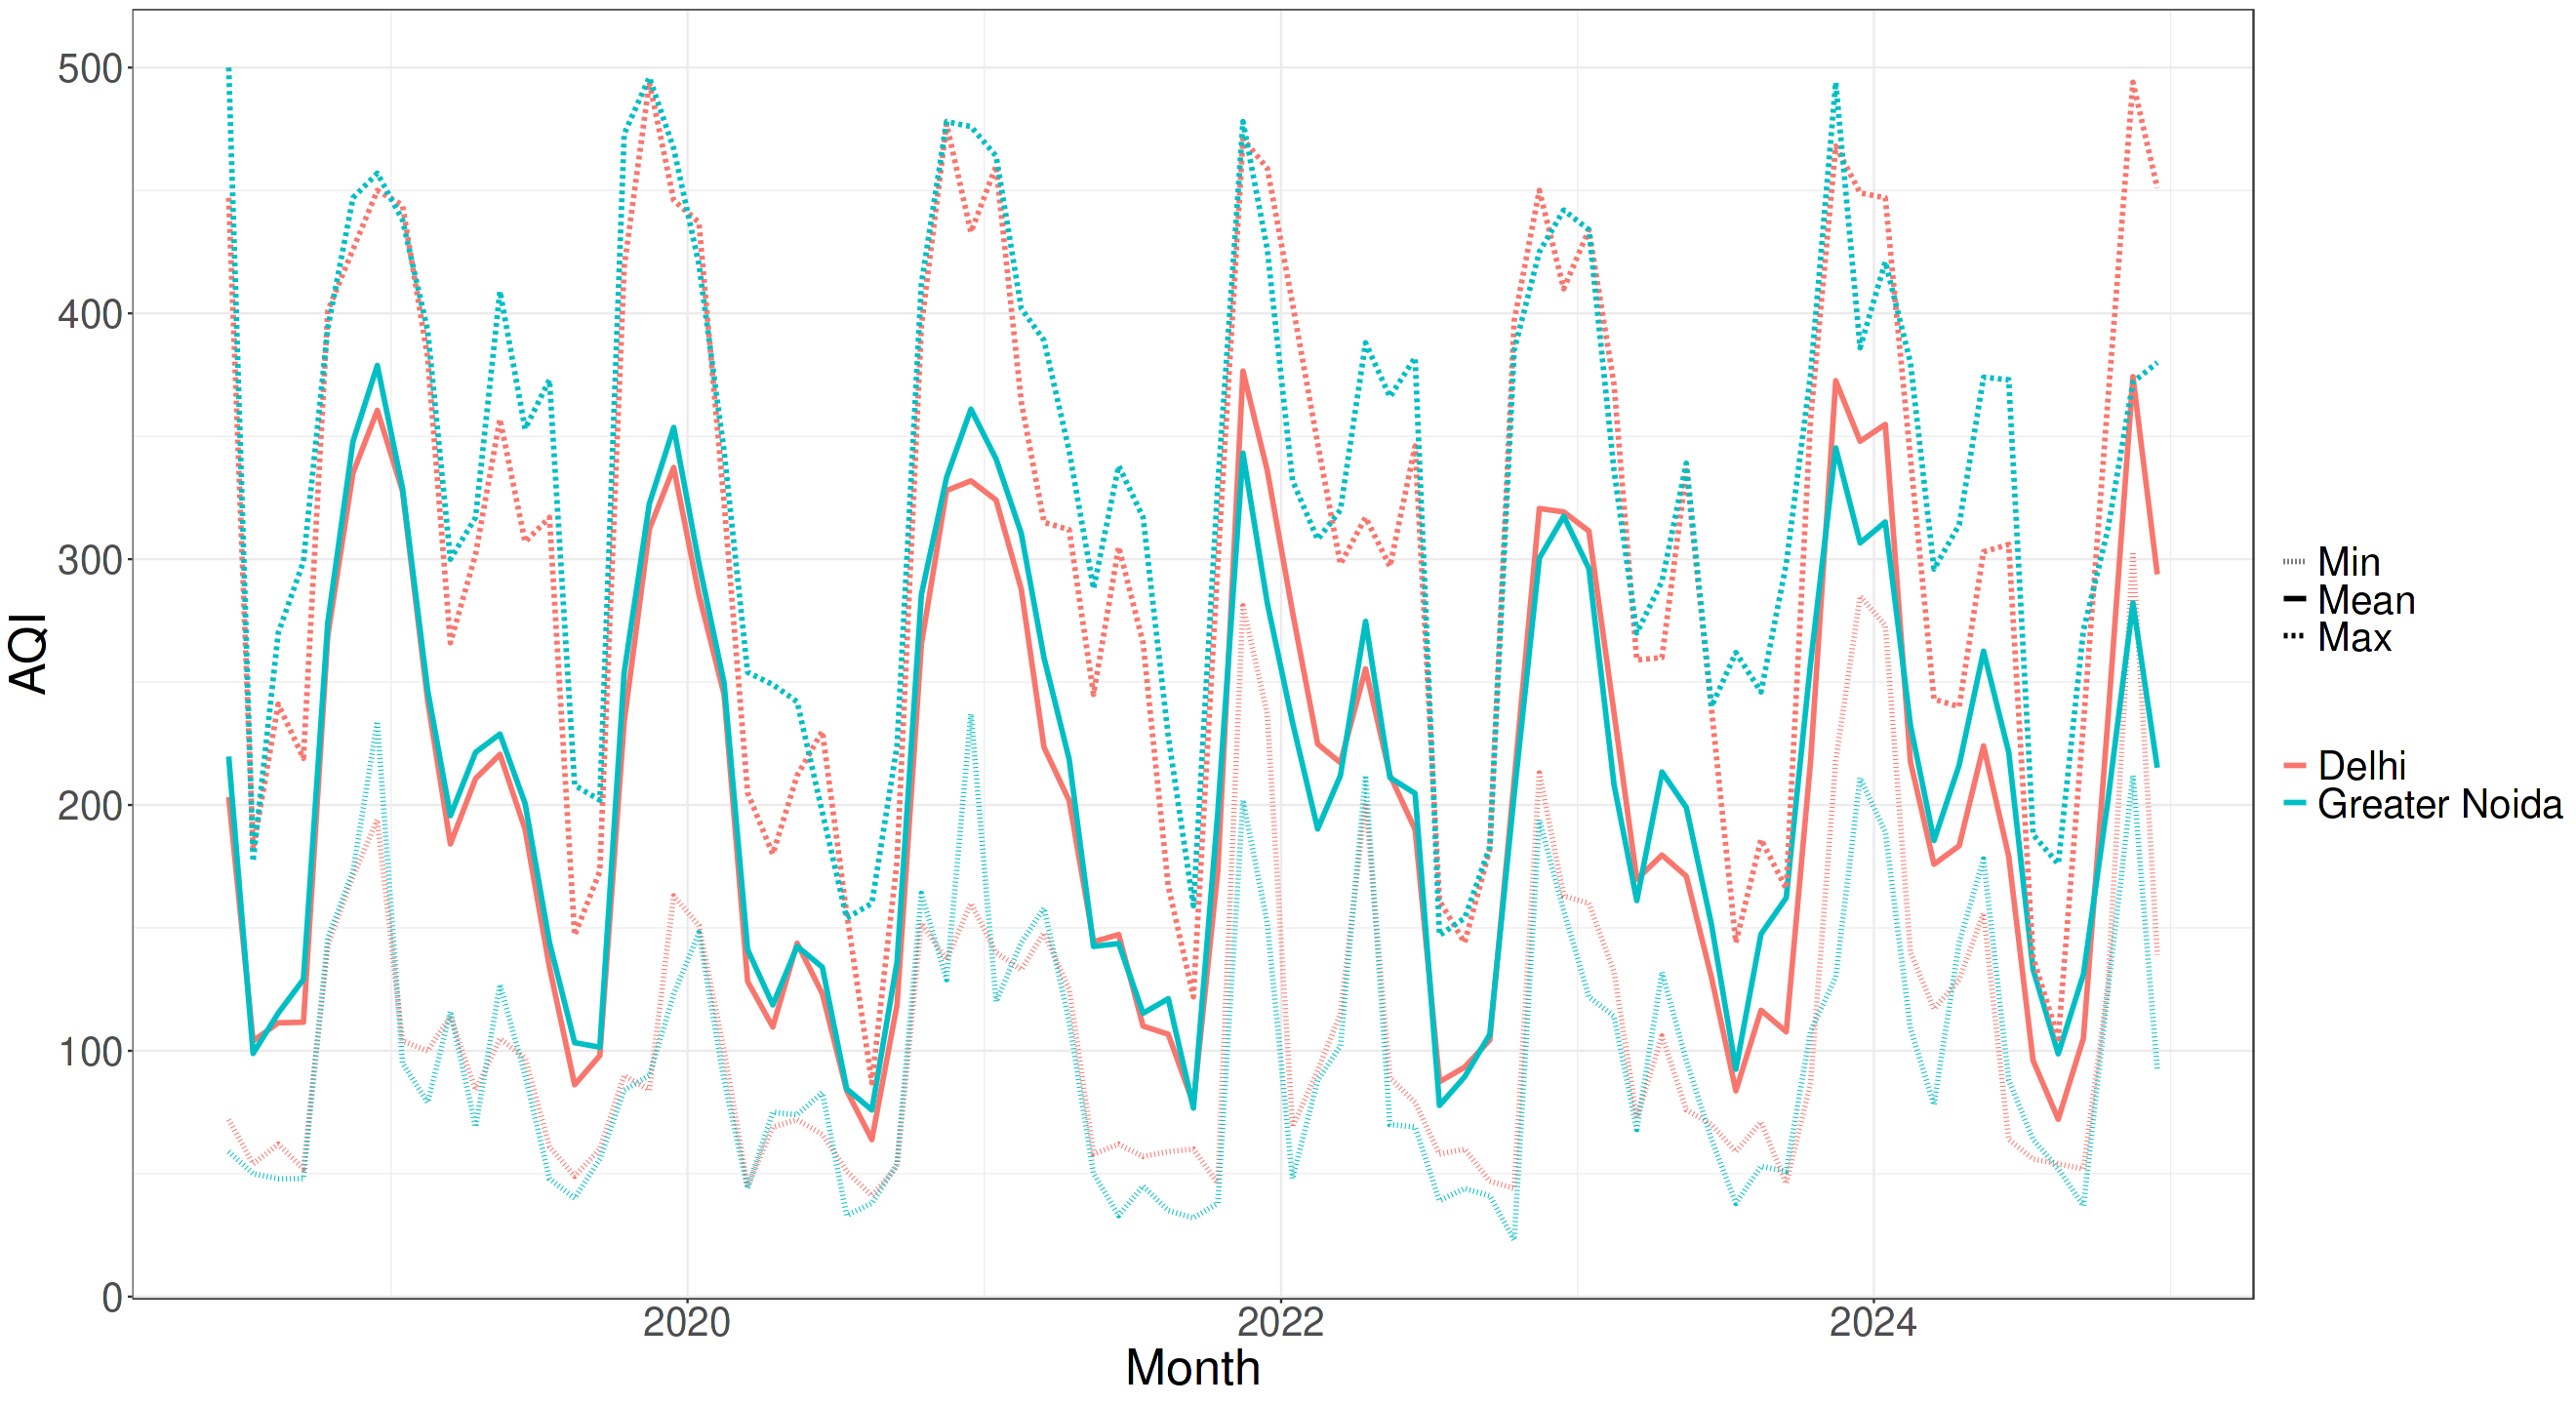

In [108]:
p <- aqi[Date>"2018-06-01",
         .(Min = min(aqi),
           Mean = mean(aqi),
           Max = max(aqi)),
         .(City,
           Date=as.Date(paste0(year(Date), "-",
                               month(Date), "-15"
                      )))]

p <- melt(p,id=c("City", "Date"))
ggplot(p, aes(x = Date, y=value, linetype=variable, colour = City, group = interaction(City,variable))) +
geom_line(linewidth=1.2) +
scale_x_date("Month") +
scale_y_continuous("AQI") +
scale_linetype_manual("", values=c("dotted", "solid", "dashed"))+
scale_colour_discrete("") +
theme_bw() + theme(text=element_text(size=30))
#

# Standard Deviation of AQI

In [115]:
t <- aqi[,.(SD = round(var(aqi^0.5),1)),.(City, year(Date))]
dcast.data.table(t, year~City)

Using 'SD' as value column. Use 'value.var' to override



year,Delhi,Greater Noida
<int>,<dbl>,<dbl>
2017,12.0,NA
2018,12.7,19.3
2019,13.5,14.0
2020,15.1,16.1
2021,14.7,15.6
2022,12.7,13.5
2023,13.4,10.9
2024,13.5,8.9


# Correlation

* The correlation coefficient of AQI between Delhi and Greater Noida is 0.936, which is very high.
* This confirms that the causes of air pollution are common between Delhi and Greater Noida.

In [116]:
t <- dcast(aqi, Date~City, value.var="aqi")
names(t) <- c("Date", "Delhi", "Greater_Noida")
t <- t[!is.na(Greater_Noida)]
cor(t$Delhi, t$Greater_Noida)


[1] 0.936259